In [1]:
import numpy as np
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
nruns=64
run='hpc_pop_4m'

selected_spsp = []
nzs = []
ndens = []
for i in range(nruns):
    #selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))
    ndens.append(np.load("nz_samples/n_detected_"+run+"_"+str(i)+".npy"))

#selected_spsp = np.vstack(selected_spsp)
nzs = np.vstack(nzs)
ndens = np.vstack(ndens)
#print(selected_spsp.shape, nzs.shape, ndens.shape)
print(nzs.shape, ndens.shape)

(1024, 3) (1024, 3)


In [3]:
real = 0
ndropouts=3
means = np.empty((16*nruns, 3))
for drop in range(ndropouts):
    for real in range(nzs.shape[0]):
        mean_redshift  = np.mean(nzs[real][drop])
        means[real][drop] = mean_redshift

np.save("nz_samples/means_nz_"+run+".npy", means)

In [4]:
test = np.load("nz_samples/means_nz_"+run+".npy")

In [5]:
def plot_nzs(axes, nzs, mean, density, a, p, **kwargs):

    ndropouts = 3

    percentile=p

    bin_step = 0.1
    bin_start = 0
    bin_end = 7

    bins = np.arange(bin_start, bin_end, bin_step)
    colours = ['purple', 'black', 'red']
    labels = ['$u$-dropouts', "$g$-dropouts", "$r$-dropouts"]
    lss=['--', '-.', '-']


    samples=100
    grid = np.arange(bin_start, bin_end-bin_step, bin_step/samples)

    for drop in range(ndropouts):

        values = []
        for ind in range(nzs.shape[0]):
            hist = np.histogram(nzs[ind][drop], density=density, bins=bins)
            oversampled_values = np.repeat(hist[0], samples)
            values.append(oversampled_values)

        values = np.vstack((np.array(values)))
        mean_at_grid_point = np.mean(values, axis=0)
        percentile_at_point = np.percentile(values, [100-percentile, 50, percentile], axis=0)
        if(mean):
            axes.plot(grid, mean_at_grid_point, c=colours[drop], **kwargs, label=labels[drop], ls=lss[drop], lw=2)
        axes.fill_between(grid, percentile_at_point[0, :], percentile_at_point[2, :], alpha=a, color=colours[drop], lw=0)

    axes.legend(fontsize=18, ncol=3, loc='upper left')
    axes.set_xlabel("Redshift $z$", fontsize=24)
    axes.set_ylabel("$p$($z$|Dropout Selection, SPS Model)", fontsize=24)
    axes.set_xticks(np.arange(0, 7, 0.5))
    axes.tick_params('x', labelsize=24)
    axes.tick_params('y', labelsize=24)
    axes.grid(alpha=0.2)
    axes.set_xlim(0, 6)
    axes.set_ylim(0, 1.8)

/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_98054/2118944862.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend(fontsize=18, ncol=3, loc='upper left')


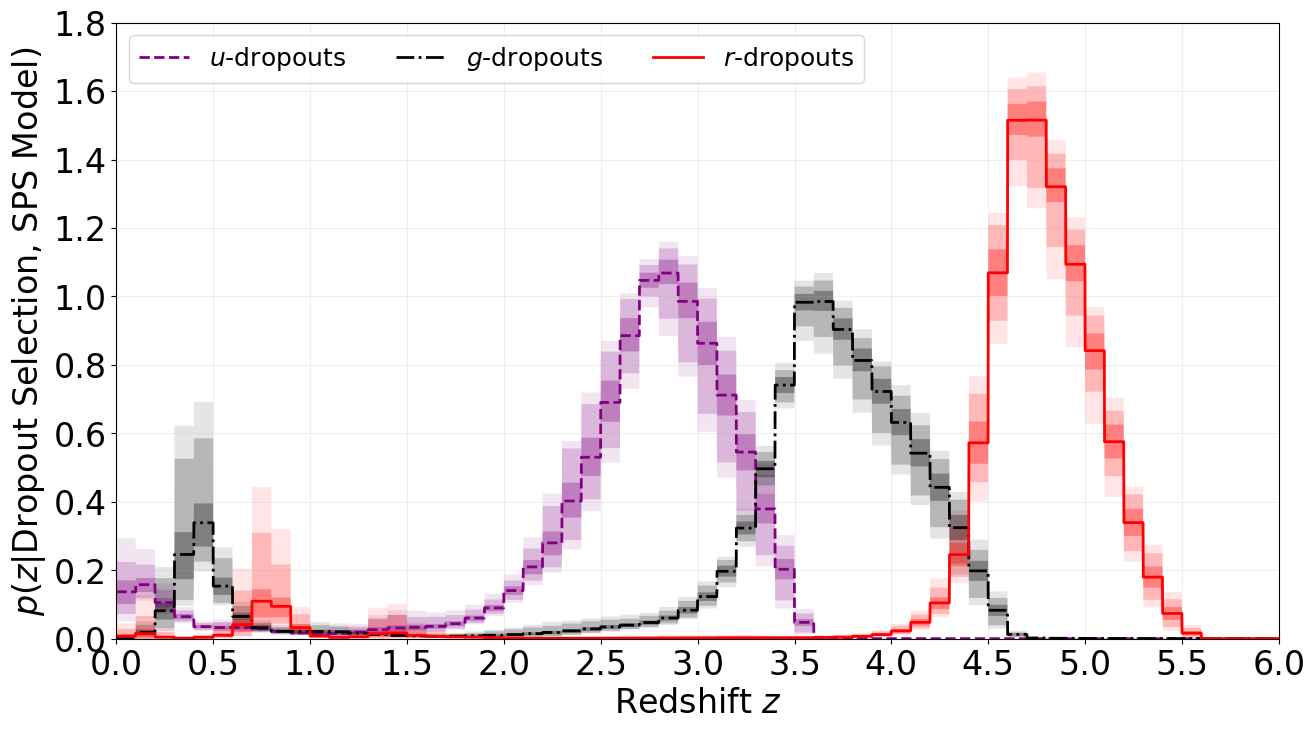

In [6]:
density=True
fig1, axes = plt.subplots(1, 1, figsize=(15,8), sharex=False, sharey=False)
plot_nzs(axes, nzs, mean=False, density=density, ls='--', a=0.1, p=99.7)
plot_nzs(axes, nzs, mean=False, density=density, ls='--', a=0.2, p=97.5)
plot_nzs(axes, nzs, mean=True, density=density, a=0.3, p=84)

In [7]:
percentile=84
mean = np.mean(ndens, axis=0)
std =  np.std(ndens, axis=0)
errl = np.percentile(ndens, 100-percentile, axis=0)
errh = np.percentile(ndens, percentile, axis=0)

print("u-dropout number density (std): ",mean[0],"+/-",std[0],"deg-2")
print("g-dropout number density (std): ",mean[1],"+/-",std[1],"deg-2")
print("r-dropout number density (std): ",mean[2],"+/-",std[2],"deg-2")


ww_mag = [25.7022696929239, 26.503337783711615, 25.80373831775701]
ww_n = [14221.361534067577, 13866.10741847241, 1318.8615021762366]

print("W&W u-dropout number density: ",ww_n[0],"deg-2")
print("W&W g-dropout number density: ",ww_n[1],"deg-2")
print("W&W r-dropout number density: ",ww_n[2],"deg-2")

u-dropout number density (std):  8421.989718486142 +/- 1252.7869226146818 deg-2
g-dropout number density (std):  14400.170255309402 +/- 2153.6104882325635 deg-2
r-dropout number density (std):  1154.1679506696107 +/- 352.28113363591575 deg-2
W&W u-dropout number density:  14221.361534067577 deg-2
W&W g-dropout number density:  13866.10741847241 deg-2
W&W r-dropout number density:  1318.8615021762366 deg-2


u-dropout Interloper Fraction: 7.393931652767657 +/- 1.1533045943770168
g-dropout Interloper Fraction: 10.592738909926021 +/- 2.850106880368895
r-dropout Interloper Fraction: 3.6913567073280413 +/- 1.873280884945516


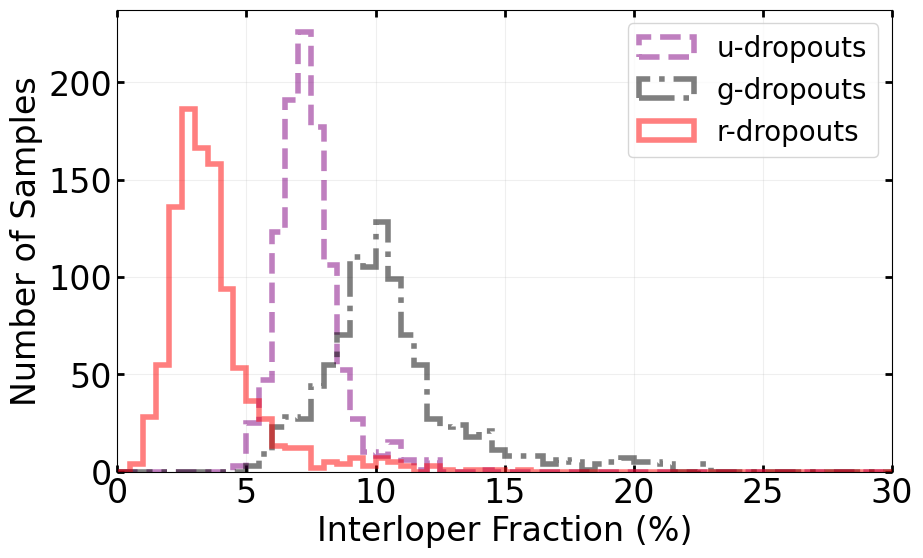

In [8]:
def interlopers(samples):
    nint = len(np.where(samples<1.5)[0])
    ntot = len(samples)
    return (nint/ntot)*100

f, ax = plt.subplots(1, 1, figsize=(10, 6))

uints = []
gints = []
rints = []
for n in range(nzs.shape[0]):
    uints.append(interlopers(nzs[n][0]))
    gints.append(interlopers(nzs[n][1]))
    rints.append(interlopers(nzs[n][2]))

nbins = np.arange(0.0, 100, 0.5)
histogram = ax.hist(uints, alpha=0.5, bins=nbins, color='purple', histtype='step', lw=4, ls='--', label='u-dropouts')
histogram = ax.hist(gints, alpha=0.5, bins=nbins, color='black', histtype='step', lw=4, ls='-.', label='g-dropouts')
histogram = ax.hist(rints, alpha=0.5, bins=nbins, color='red', histtype='step', lw=4, ls='-', label='r-dropouts')

uints_mean = np.mean(uints)
uints_std = np.std(uints)
gints_mean = np.mean(gints)
gints_std = np.std(gints)
rints_mean = np.mean(rints)
rints_std = np.std(rints)

print("u-dropout Interloper Fraction:", uints_mean,"+/-",uints_std)
print("g-dropout Interloper Fraction:", gints_mean,"+/-",gints_std)
print("r-dropout Interloper Fraction:", rints_mean,"+/-",rints_std)

ax.set_xticks(np.arange(0, 35, 5))

ax.set_xlim(0, 30)
ax.grid(alpha=0.2)
ax.set_xlabel("Interloper Fraction (%)", fontsize=24)
ax.set_ylabel("Number of Samples", fontsize=24)
ax.tick_params('x', labelsize=24, width=2, size=5, direction='in', top=True)
ax.tick_params('y', labelsize=24, width=2, size=5, direction='in', right=True)

ax.legend(ncols=1, fontsize=20)


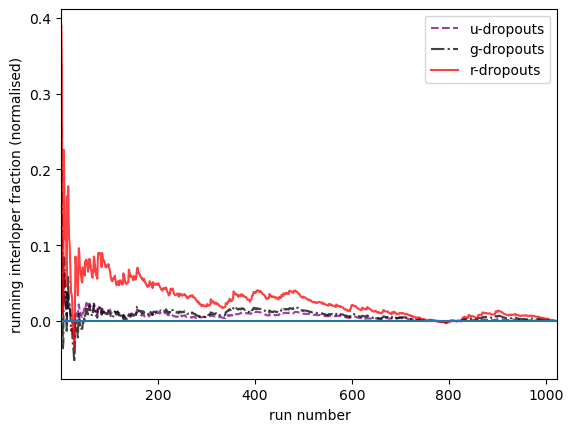

In [9]:
uint_arr = np.array(uints)
gint_arr = np.array(gints)
rint_arr = np.array(rints)

nruns = np.arange(1, uint_arr.shape[0]+1)

plt.plot(nruns, (np.cumsum(uint_arr)/nruns-uints_mean)/uints_mean, color='purple', alpha=0.75,ls='--', label='u-dropouts')
plt.plot(nruns, (np.cumsum(gint_arr)/nruns-gints_mean)/gints_mean, color='black', alpha=0.75,ls='-.', label='g-dropouts')
plt.plot(nruns, (np.cumsum(rint_arr)/nruns-rints_mean)/rints_mean, color='red', alpha=0.75,ls='-', label='r-dropouts')
plt.xlim(nruns[0], nruns[-1])
plt.legend()
plt.ylabel('running interloper fraction (normalised)')
plt.xlabel('run number')

plt.plot([nruns[0], nruns[-1]], [0, 0])

In [10]:
#from getdist import plots
#from getdist import MCSamples

#real=0
#taus = np.squeeze(selected_spsp[real, 0])[:, 2:4]
#zs = np.squeeze(selected_spsp[real, 0])[:, 0]

#mcsamp = MCSamples(samples=np.vstack((zs, taus[:, 0])).T, names=['z', 'tau1'])
#g = plots.get_single_plotter()
#g.plot_2d([mcsamp], 'z', 'tau1')

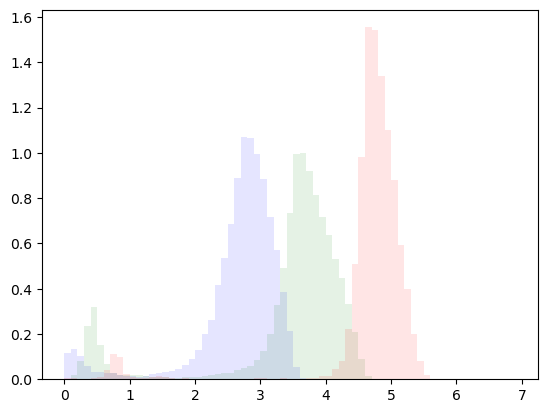

In [11]:
bins = nz.default_nz_bins()
indx=np.random.randint(0, nzs.shape[0])
hist = plt.hist(nzs[indx][0], density=True, bins=bins, alpha = 0.1, color='blue')
hist = plt.hist(nzs[indx][1], density=True, bins=bins, alpha = 0.1, color='green')
hist = plt.hist(nzs[indx][2], density=True, bins=bins, alpha = 0.1, color='red')

In [12]:
np.save("redshifts/emulated_redshifts_0.npy", nzs)